# Install the tensorflow- addons

In [77]:
!pip install -U tensorflow-addons

# Setup

In [78]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

# prepare the data

In [79]:
num_classes = 100
input_shape = (32,32,3)
(x_train,y_train) ,(x_test,y_test) = keras.datasets.cifar100.load_data()
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


[86]


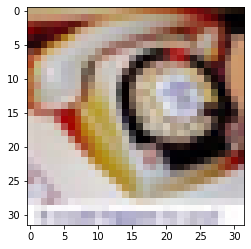

In [80]:
plt.imshow(x_train[5])
print(y_train[5])

# configure the hyperparameters

In [81]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72 # we'll resize input images to this size
patch_size=6 #size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim =64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
] # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024] #Size of the dense layers of the final classifier

# Use data augmentation

In [82]:
data_augmentation = keras.Sequential(
[
    layers.experimental.preprocessing.Normalization(),
    layers.experimental.preprocessing.Resizing(image_size, image_size),
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(factor = 0.02),
    layers.experimental.preprocessing.RandomZoom(
        height_factor = 0.2 , width_factor = 0.2
    ),
],
    name = "data_augmentaion",
)
#compute the mean and the variance of the training data for normalization
layer =data_augmentation.layers[0]
layer.adapt(x_train)
normalized_data = layer(x_train)
print("Features mean: %.2f" % (normalized_data.numpy().mean()))
print("Features std: %.2f" % (normalized_data.numpy().std()))

Features mean: -0.00
Features std: 1.00


# Implement multiplayer perceptron (MLP)

In [83]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x =layers.Dense(units, activation = tf.nn.gelu)(x)
        x =layers.Dropout(dropout_rate)(x)
    return x

# Implement patch creation as a layer

In [84]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches , self).__init__()
        self.patch_size = patch_size
    
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
        images = images,
        sizes = [1,self.patch_size,self.patch_size,1],
        strides= [1,self.patch_size,self.patch_size ,1],
        rates = [1,1,1,1],
        padding = "VALID",
        )
        patch_dim = patches.shape[-1]
        patches = tf.reshape(patches , [batch_size, -1 , patch_dim])
        return patches

let's display patches for a sample image

Image size: 72 X 72
patch Size: 6 X 6
Patches per image: 144
Element per patch: 108


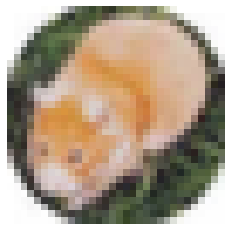

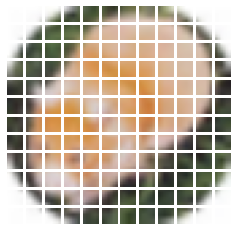

In [85]:
plt.figure(figsize= (4,4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size , image_size)
)

patches= Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"patch Size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Element per patch: {patches.shape[-1]}")

n= int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))
for i , patch in enumerate(patches[0]):
    ax = plt.subplot(n,n,i+1)
    patch_img = tf.reshape(patch, (patch_size , patch_size , 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")



# Implement the patch encoding layer
The patchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector. 

In [86]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


# Build the ViT model
The ViT model consists of multiple Transformer blocks, which use the layers.MultiHeadAttention layer as a self-attention machanism applied to the sequence of patches. The Transformer blocks produce a [batch_size, num_patchs , projection_dim] tensor, which is processed via an classifier head with softmax to produce the final class probabilities output.

Unlike the technique describe in the paper, which prepends a learnable embedding to thr sequence of encoded patches to serve as the image representation, all the output of the final Transformer blocks are reshaped with layers.Flatten() and used as the image representation input to the classifier head. Note that the layers.GlobalAveragePooling1d layer could also be used instead to aggregate the output of the Transformer block, especially when the number of patches and the projection dimensions are large.

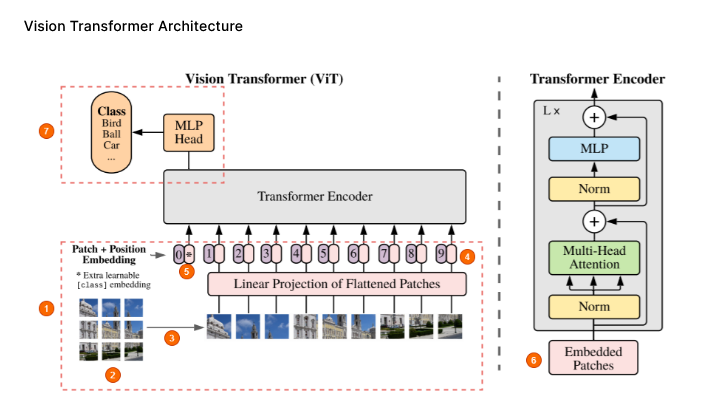

In [87]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    #Augment data
    augmented = data_augmentation(inputs)
    #create patches
    patches = Patches(patch_size)(augmented)
    #Encode patches
    encoded_patches = PatchEncoder(num_patches , projection_dim)(patches)
    
    #Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        #Layer normalization 1.
        x1 =layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        #create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(num_heads = num_heads,key_dim = projection_dim, dropout = 0.1)(x1,x1)
        #skip connection 1.
        x2 = layers.Add()([attention_output , encoded_patches])
        #Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon = 1e-6)(x2)
        #MLP
        x3 = mlp(x3, hidden_units = transformer_units, dropout_rate = 0.1)
        #skip connection 2.
        encoded_patches = layers.Add()([x3,x2])
        
        
    #Create [batch_size , projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon = 1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    #Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    #create the keras model.
    model = keras.Model(inputs = inputs,outputs = logits)
    return model

    

# Compile , train and evaluate the model

In [89]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(learning_rate = learning_rate, weight_decay = weight_decay)
    
    model.compile(
    optimizer= optimizer,
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name = "accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name = "top-5-accuracy"),
        ],
    )
    checkpoint_filepath = 'checkpoint/'
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only = True,
    save_weights_only = True,
    )
    
    history = model.fit(
        x=x_train,
        y= y_train,
        batch_size = batch_size,
        epochs= num_epochs,
        validation_split = 0.1,
        callbacks = [checkpoint_callback],
    )
    
    model.load_weights(checkpoint_filepath)
    _, accuracy , top_5_accuracy = model.evaluate(x_test , y_test)
    print(f"Test accuracy: {round(accuracy*100,2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy*100,2)}%")
    return history
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
176/176 [==============================] - 3874s 22s/step - loss: 4.8816 - accuracy: 0.0310 - top-5-accuracy: 0.1162 - val_loss: 3.9395 - val_accuracy: 0.1070 - val_top-5-accuracy: 0.3060
Epoch 2/100
176/176 [==============================] - 3331s 19s/step - loss: 4.0335 - accuracy: 0.0821 - top-5-accuracy: 0.2639 - val_loss: 3.6091 - val_accuracy: 0.1600 - val_top-5-accuracy: 0.4150
Epoch 3/100
176/176 [==============================] - 3385s 19s/step - loss: 3.7502 - accuracy: 0.1195 - top-5-accuracy: 0.3447 - val_loss: 3.3615 - val_accuracy: 0.1924 - val_top-5-accuracy: 0.4648
Epoch 4/100
176/176 [==============================] - 3311s 19s/step - loss: 3.5625 - accuracy: 0.1523 - top-5-accuracy: 0.4043 - val_loss: 3.2353 - val_accuracy: 0.2174 - val_top-5-accuracy: 0.5056
Epoch 5/100
176/176 [==============================] - 3216s 18s/step - loss: 3.4009 - accuracy: 0.1770 - top-5-accuracy: 0.4487 - val_loss: 3.0964 - val_accuracy: 0.2508 - val_top-5-accuracy: 0.5374


KeyboardInterrupt: 